# Import Libraries

In [421]:
from dash import Dash, html, dcc, callback, Output, Input, State
import dash_bootstrap_components as dbc
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash.exceptions import PreventUpdate

import pandas as pd
import numpy as np

import json

# Initialize App 

In [227]:
app = Dash(
    __name__,
    external_stylesheets=[
        dbc.themes.BOOTSTRAP,
        dbc.icons.FONT_AWESOME
    ]
)

# Load Data

In [228]:
athlete_events_df = pd.read_csv("./assets/athlete_events.csv")
noc_regions_df = pd.read_csv("./assets/noc_regions.csv")

# Total Medal Count by Height and Weight, grouped by Sport (Heatmap Figure)

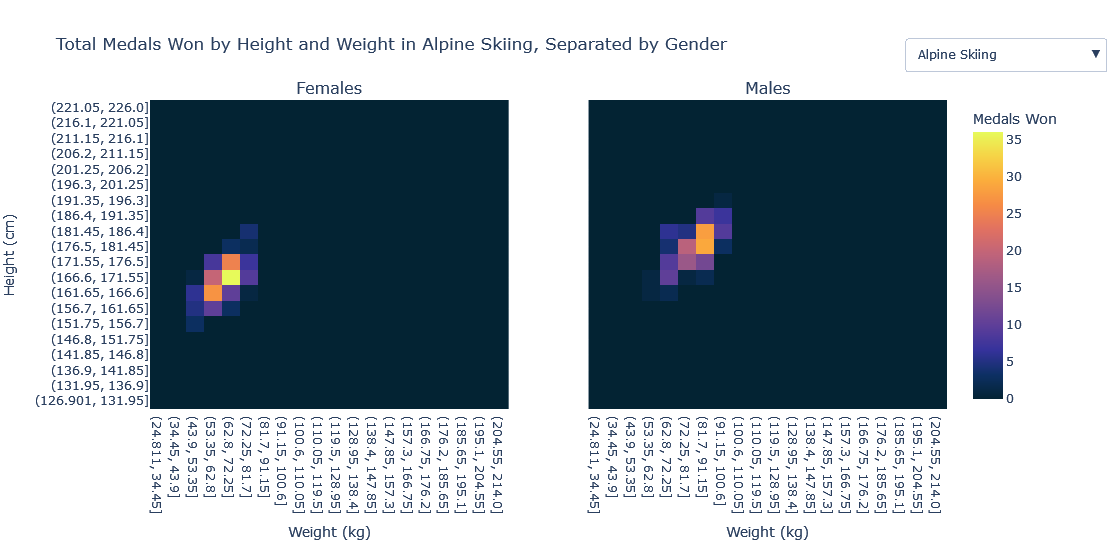

In [592]:
# Create bins for height and weight
height_weight_medal_df = athlete_events_df.copy()
height_weight_medal_df = height_weight_medal_df.dropna(subset=["Height", "Weight"])
height_weight_medal_df["Height Bin"] = pd.cut(height_weight_medal_df["Height"], bins=20)
height_weight_medal_df["Weight Bin"] = pd.cut(height_weight_medal_df["Weight"], bins=20)

# Group by sports, separated by sex
height_weight_medal_df = height_weight_medal_df.groupby(["Sport", "Sex", "Height Bin", "Weight Bin"], observed=False)["Medal"].count().reset_index(name="Medal Count")

# Create pivot tables for each sport and sex
sports_df_list = {}
for (col, sport) in height_weight_medal_df.groupby("Sport"):
    sports_df_list[col] = {}
    for (c, sex) in sport.groupby("Sex"):
        sports_df_list[col][c] = pd.pivot_table(sex, index="Height Bin", columns="Weight Bin", values="Medal Count", observed=False).fillna(0)
for sport in sports_df_list.keys():
    for sex in sports_df_list[sport]:
        sports_df_list[sport][sex].columns = sports_df_list[sport][sex].columns.astype(str)
        sports_df_list[sport][sex].index = sports_df_list[sport][sex].index.astype(str)
        
# Create heatmap subplot figure
heatmap_fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=("Females", "Males"),
    shared_yaxes=True
)

# Starting heatmap
heatmap_fig.add_trace(
    go.Heatmap(
        x=sports_df_list["Alpine Skiing"]["F"].columns,
        y=sports_df_list["Alpine Skiing"]["F"].index,
        z=sports_df_list["Alpine Skiing"]["F"].values,
        visible=True,
        hovertemplate=
            "<b>Height Bin:</b> %{y}cm<br>" +
            "<b>Weight Bin:</b> %{x}kg<br>" +
            "<b>Total Medals Won:</b> %{z}",
        name="",
        coloraxis="coloraxis"
    ),
    row=1,
    col=1
)
heatmap_fig.add_trace(
    go.Heatmap(
        x=sports_df_list["Alpine Skiing"]["M"].columns,
        y=sports_df_list["Alpine Skiing"]["M"].index,
        z=sports_df_list["Alpine Skiing"]["M"].values,
        visible=True,
        hovertemplate=
            "<b>Height Bin:</b> %{y}cm<br>" +
            "<b>Weight Bin:</b> %{x}kg<br>" +
            "<b>Total Medals Won:</b> %{z}",
        name="",
        # colorscale="coloraxis"
        coloraxis="coloraxis"
    ),
    row=1,
    col=2
)
heatmap_fig.update_layout(
    title="Total Medals Won by Height and Weight in Alpine Skiing, Separated by Gender"
)

# Add heatmap traces for each sport
for i, sport in enumerate(sports_df_list.keys()):
    for j, sex in enumerate(sports_df_list[sport]):
        heatmap_fig.add_trace(
            go.Heatmap(
                x=sports_df_list[sport][sex].columns,
                y=sports_df_list[sport][sex].index,
                z=sports_df_list[sport][sex].values,
                visible=False,
                hovertemplate=
                    "<b>Height Bin:</b> %{y}cm<br>" +
                    "<b>Weight Bin:</b> %{x}kg<br>" +
                    "<b>Total Medals Won:</b> %{z}",
                name="",
                coloraxis="coloraxis"
            ),
            row=1,
            col=j + 1
        )

# Create dropdown option for each sport
sports_options = []
for i, key in enumerate(sports_df_list.keys()):
    visible_list = [False] * (len(sports_df_list.keys()) + 2) * 2
    visible_list[i * 2 + 2] = True
    visible_list[i * 2 + 3] = True
    sports_options.append(dict(
        label=key,
        method="update",
        args=[
            {"visible":visible_list},
            {"title":f"Total Medals Won by Height and Weight in {key}, Separated by Gender"}
        ]
    ))
    
heatmap_fig.update_layout(
    width=1000,
    height=550,
    autosize=False,
    coloraxis=dict(
        colorscale="thermal",
        colorbar=dict(
            title="Medals Won"
        )
    ),
    updatemenus=[dict(
        active=0,
        buttons=sports_options,
        x=1.2,
        y=1.2
    )]
)

heatmap_fig.update_xaxes(
    title_text="Weight (kg)",
    row=1,
    col=1
)
heatmap_fig.update_xaxes(
    title_text="Weight (kg)",
    row=1,
    col=2
)
heatmap_fig.update_yaxes(
    title_text="Height (cm)",
    row=1,
    col=1
)
    
heatmap_fig.show()

# Interactive Map (Choropleth Figure)

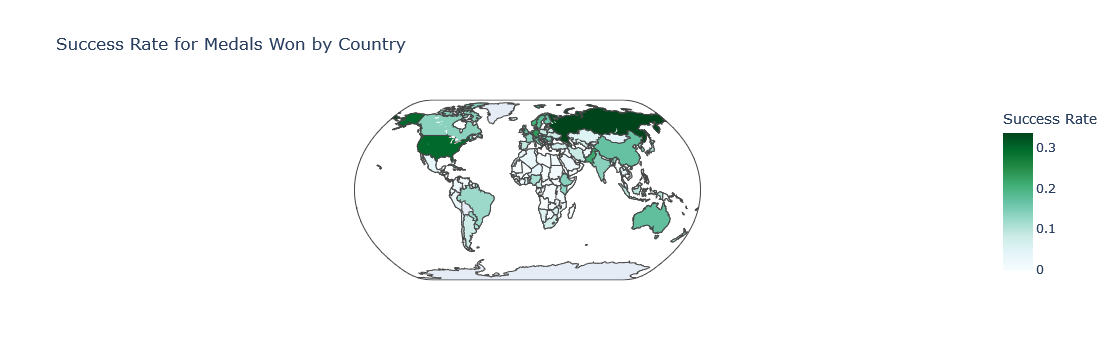

In [146]:
# Group total medals won by NOC, removing duplicates from individuals winning medals from team sports to only count one medal
# medals_country_df = athlete_events_df.dropna(subset=["Medal"])
# medals_country_df = medals_country_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event", "Medal"])
# medals_country_df = medals_country_df.merge(noc_regions_df, on="NOC", how="left")
# medals_country_df = medals_country_df.groupby(["region", "Medal"])["Medal"].count().unstack(fill_value=0).stack().reset_index(name="Medal Count")
# medals_country_df = medals_country_df.groupby(["region"])["Medal Count"].sum().reset_index(name="Total Medals")


medals_won_df = athlete_events_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event"])
medals_won_df = athlete_events_df.merge(noc_regions_df, on="NOC", how="left")
medals_won_df = medals_won_df.groupby(["region"])["Medal"].count().reset_index(name="Won")

medals_attempted_df = athlete_events_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event"])
medals_attempted_df = athlete_events_df.merge(noc_regions_df, on="NOC", how="left")
medals_attempted_df["Medal"] = medals_attempted_df["Medal"].fillna("None")
medals_attempted_df = medals_attempted_df.groupby(["region"])["Medal"].count().reset_index(name="Attempted")

success_rate_df = medals_won_df.merge(medals_attempted_df, on="region", how="left")
success_rate_df["Success Rate"] = success_rate_df["Won"] / success_rate_df["Attempted"]
success_rate_df[success_rate_df["region"] == "Norway"]
# success_rate_df.sort_values(by="Success Rate", ascending=False)

# Choropleth figure
choropleth_fig = px.choropleth(
    success_rate_df,
    title="Success Rate for Medals Won by Country",
    locations="region",
    locationmode="country names",
    hover_name="region",
    hover_data=dict(
        region=False
    ),
    color="Success Rate",
    color_continuous_scale="BuGn",
    projection="natural earth"
)
choropleth_fig.show()

# Country Data Drill-In

In [ ]:
# Group total medals won by NOC, removing duplicates from individuals winning medals from team sports to only count one medal
medals_distribution_df = athlete_events_df.dropna(subset=["Medal"])
medals_distribution_df = medals_distribution_df.drop_duplicates(subset=["NOC", "Games", "Year", "Season", "City", "Sport", "Event", "Medal"])
medals_distribution_df = medals_distribution_df.merge(noc_regions_df, on="NOC", how="left")
medals_distribution_df = medals_distribution_df.groupby(["region", "Medal"])["Medal"].count().unstack(fill_value=0).stack().reset_index(name="Medal Count")

medals_perc_df = athlete

# List of medals won by NOC
noc_df_list = {col:noc for (col, noc) in medals_distribution_df.groupby("region")}

# Bar figure
medals_fig_list = {}
for key, noc in noc_df_list.items():
    medals_fig_list[key] = go.Figure(
        data=go.Bar(
            x=noc["Medal"],
            y=noc["Medal Count"]
        )
    )
medals_fig_list

# Dash Layout

In [ ]:
choropleth_fig.update_layout(clickmode='event+select')

app.layout = html.Div([
    dcc.Graph(
        id="choropleth",
        figure=choropleth_fig
    ),
    dcc.Graph(
        id="heatmap",
        figure=heatmap_fig
    ),
    dbc.Modal([
        dbc.ModalHeader(dbc.ModalTitle(id="modal-text", children=[
            "Placeholder"
        ])),
        dcc.Graph(
            id="drill-in",
            figure=medals_fig_list["USA"]
        )],
        id="modal-sm",
        size="sm",
        is_open=False,
    )
])

@callback([
        Output("modal-text", "children"),
        Output("modal-sm", "is_open"),
        Output("drill-in", "figure")
    ],
    [Input("choropleth", "clickData")],
    [
        State("modal-sm", "is_open"),
        State("drill-in", "figure")
    ]
)
def update_modal(clickData, is_open, figure):
    if clickData is None:
        raise PreventUpdate
    if is_open is None:
        raise PreventUpdate
    if figure is None:
        raise PreventUpdate
        
    if clickData:
        print(medals_fig_list[clickData["points"][0]["hovertext"]])
        return clickData["points"][0]["location"], not is_open, medals_fig_list[clickData["points"][0]["hovertext"]]
    return None, is_open, None

# Run Dash App

In [ ]:
app.run_server(debug=True)